In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from graphviz import Digraph

def draw_dot(root):
    def trace(root):
        # builds a set of all nodes and edges in a graph
        nodes, edges = set(), set()

        def build(root):
            if root not in nodes:
                nodes.add(root)
                for child in root.prev:
                    edges.add((child, root))
                    build(child)

        build(root)
        return nodes, edges

    dot = Digraph(graph_attr={'rankdir': 'LR'}, format='svg')

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid,
                 label="{ %s | data=%0.4f | grad=%0.4f}" % (
                     node.name, node.val, node.grad),
                 shape='record')

        if node.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + node.op, label=node.op)
            # and connect this node to it
            dot.edge(uid + node.op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot


In [3]:
from __future__ import annotations
from cmath import isfinite
from typing import List, Union
import uuid


class Scalar:
    def __init__(self,
                 val: Union[float, int],
                 name: str = '',
                 prev: tuple[Scalar] = (),
                 op: str = '') -> None:

        assert isinstance(
            val, (float, int)), "val must be a float or an integer"

        self.val = val
        self.name = name
        self.prev = set(prev)
        self.op = op
        self.grad = 0.0
        self._backward = lambda: None

    def exp(self) -> Scalar:
        x = self.val
        output = Scalar(math.exp(x), prev=(self, ), op='exp')
        
        def _backward():
            self.grad += output.val * output.grad
        output._backward = _backward

        return output

    def tanh(self) -> Scalar:
        x = self.val
        tanh = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Scalar(tanh, prev=(self, ), op='tanh')

        def _backward():
            self.grad += (1.0 - tanh**2) * output.grad
        output._backward = _backward 

        return output 

    def backward(self) -> None:
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __add__(self, other) -> Scalar:
        other = other if isinstance(other, Scalar) else Scalar(other)
        output = Scalar(self.val + other.val, prev=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        output._backward = _backward 

        return output

    def __mul__(self, other) -> Scalar:
        other = other if isinstance(other, Scalar) else Scalar(other)
        output = Scalar(self.val * other.val, prev=(self, other), op='*')

        def _backward():
            self.grad += other.val * output.grad
            other.grad += self.val * output.grad
        output._backward = _backward 

        return output 

    def __radd__(self, other) -> Scalar:
        return self + other

    def __rmul__(self, other) -> Scalar:
        return self * other

    def __neg__(self) -> Scalar:
        return self * -1

    def __sub__(self, other) -> Scalar:
        return self + (-other)

    def __rsub__(self, other) -> Scalar:
        return other + (-self)

    def __pow__(self, other) -> Scalar:
        assert isinstance(
            other, (float, int)), 'class Scalar can only be raised by the power of an integer or a float'
        
        output = Scalar(self.val ** other, prev=(self, ), op=f'**{other}')

        def _backward():
            self.grad += other * self.val ** (other - 1) * output.grad
        output._backward = _backward

        return output 

    def __truediv__(self, other) -> Scalar:
        return self * other ** -1

    def __rtruediv__(self, other) -> Scalar:
        return other * self ** -1

    def __repr__(self) -> str:
        return f'Scalar(val={self.val:0.4f}, grad={self.grad:0.4f})'


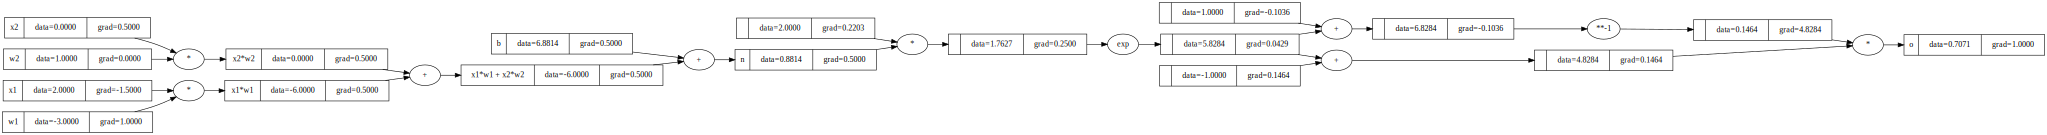

In [4]:
# inputs x1,x2
x1 = Scalar(2.0, name='x1')
x2 = Scalar(0.0, name='x2')
# weights w1,w2
w1 = Scalar(-3.0, name='w1')
w2 = Scalar(1.0, name='w2')
# bias of the neuron
b = Scalar(6.8813735870195432, name='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.name = 'x1*w1'
x2w2 = x2*w2; x2w2.name = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.name = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.name = 'o'
o.backward()
draw_dot(o)

In [5]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [6]:
from random import random
from typing import Union

class Neuron:

    def __init__(self, nin: int) -> None:
        self.nin = nin
        self.w = [Scalar(np.random.uniform(-1.0, 1.0)) for _ in range(nin)]
        self.b = Scalar(np.random.uniform(-1.0, 1.0))
    
    def __call__(self, x: Union[list, int]) -> Scalar:
        x = [x] if isinstance(x, int) else x

        assert len(x) == self.nin, "input size has to match n_inputs"

        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b) 

        return act.tanh()

    def parameters(self) -> List[Scalar]:
        return self.w + [self.b]
     

class Layer:
    
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x) -> List[Scalar]:
        output = [n(x) for n in self.neurons]
        return output[0] if len(output) == 1 else output

    def parameters(self) -> List[Scalar]:
        return [p for n in self.neurons for p in n.parameters()]
        

class MLP:

    def __init__(self, nin, nouts) -> None:
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i + 1]) for i in range(len(nouts))] 

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x
    
    def parameters(self) -> List[Scalar]:
        return [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self) -> None:
        for param in self.parameters():
            param.grad = 0.0

    def step(self, lr: float) -> None:
        for param in self.parameters():
            param.val -= lr * param.grad


In [7]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

model = MLP(3, [4, 4, 1])

In [8]:
lr = 5e-2
for t in range(200):
    y_pred = [model(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(y_pred, ys)]) 
    if t % 20 == 19:
        print(t + 1, loss.val)
    loss.backward()
    model.step(lr)
    model.zero_grad()

20 0.052878474571755624
40 0.022695127830248185
60 0.014095316212147546
80 0.01011911167917057
100 0.007850278311932309
120 0.006391394909588496
140 0.005377871230749461
160 0.004634488867603447
180 0.004066884911670469
200 0.003619860945975074
